# Análise estatística da relação entre as pesquisas eleitorais e o resultado das urnas nas eleições presidenciais de 2018

A pesquisa eleitoral atualmente é uma das formas mais comuns de se entender as preferências da população em relação a candidatos disputando eleição, recorrendo a métodos estatísticos para alcançar um alto grau de confiança com baixo custo operacional. No entanto, comumente as pesquisas eleitorais são descreditadas por imaginar-se que a quantidade de pessoas entrevistadas é muito baixa para gerar um resultado confiável. Esse trabalho procura demonstrar a matemática por trás das pesquisas de intenção de voto e entender quais informações elas de fato trazem sobre o resultado final. 

Nas análises a seguir, serão considerados apenas dois candidatos, incluindo a possibilidade de voto branco/nulo. Para fins de simplificação, a análise será feita sobre a distribuição marginal de probabilidade de um único candidato. As funções desenvolvidas serão consideradas homogêneas para toda a população, desconsiderando problemas de estratificação nas pesquisas.

In [22]:
from sympy import Symbol
from sympy import integrate 
import scipy.integrate as integ
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import matplotlib.animation as animation
from scipy.optimize import curve_fit

%matplotlib inline

## Considerações iniciais

O objetivo será encontrar a distribuição de probabilidade da intenção de voto dado a pesquisa eleitoral $f(\ p \ | \ k, N)$. Para isso, será inicialmente definida uma distribuição de probabilidade a priori $f(p)$ para um único candidato, coerente com as regras da eleição para o segundo turno.

### $f(p)$: Função distribuição de probabilidade a priori de porcentagem de voto
Assumindo as seguintes hipóteses:
* n candidatos participando;
* As probabilidades de voto em cada candidato têm soma menor igual a 1 (considera brancos e nulos);
* Cada ponto do espaço $\Lambda = \{(p_1, ..., p_n) \in {\rm I\!R} \ | \sum_{i= 1}^n p_i \leq 1\}$ é igualmente provável: desconhecimento completo.

podemos construir a função de distribuição de probabilidade uniforme $ f(p_1, ... , p_n) $. Logo, a função $f(p)$ dada corresponde à distribuição marginal para um único candidato, e é idependente de qual candidato se escolhe. 

A menos se especificado o contrário, serão considerados apenas dois candidatos (n = 2).


In [23]:
def f_p(n = 2):
    ''' f(p)
    n: numero de candidatos.
    Distribuicao marginal a priori para a probabilidade
    de se votar em determinado candidato, supondo isonomia
    entre candidatos e considerando possibilidade de voto
    branco/nulo.
    '''
    sym_list = [Symbol('v' + str(i)) for i in range(n)]
    f = 1.0
    for i in range(1,n):
        f = integrate(f, sym_list[-i])
        f = f.subs(sym_list[-i], 1.0 - sum(sym_list[:-i])) - \
            f.subs(sym_list[-i], 0)
        
    norm = integrate(f, (sym_list[0], 0.0, 1.0))
    return f/norm

#### Espaço de configurações $\Lambda$ considerado para n = 2 candidatos
Todos os pontos da área demarcada são considerados equiprováveis.

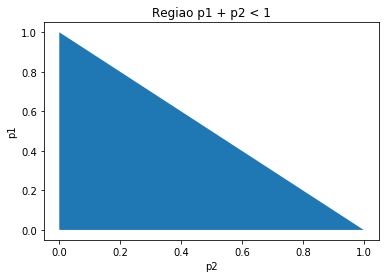

In [9]:
plt.fill_between(np.linspace(0.0, 1.0, 101), 0, 1.0 - np.linspace(0.0, 1.0, 101))
plt.ylabel('p1')
plt.xlabel('p2')
plt.title('Regiao p1 + p2 < 1')
plt.show()

#### Demonstração: $f(p)$ em função do número de candidatos

O caráter decrescente de $ f(p) $ para $ n \geq 1 $ ocorre pela competição entre os candidatos. Por exemplo, é bem menos provável de encontrar um candidato com 100% das intenções de voto, porque este compete com outro candidato a priori idêntico.

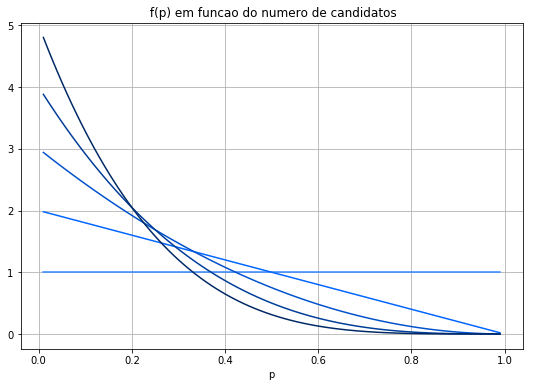

In [4]:
grid = [float(x)/100 for x in range(1,100)]
color_list = ['#3385ff','#0066ff','#0052cc','#003d99','#002966']

plt.figure(figsize=(9,6))
for index, n in enumerate([1,2,3,4,5]):
    f = f_p(n = n)
    fp_grid = [f.subs('v0', x) for x in grid]
    plt.plot(grid, fp_grid, color = color_list[index])

plt.xlabel('p')
plt.grid()
plt.title(' f(p) em funcao do numero de candidatos')
plt.show()


### $P_N(k \ | \ p)$ : Função binomial de probabilidade de amostragem k em N dada probabilidade p 

Supondo que uma fração p da população está propensa a declarar intenção de voto a um determinado candidato, a probabilidade de que k de pessoas dentre N amostras que declararão esse voto é calculada pela distribuição binomial:

$$P_N(k \ | \ p) = {N \choose k} p^{k}(1-p)^{N-k}  \ \ \ \ \ \ \ \ (1)$$

In [24]:
def P_kcp(k, N, p):
    ''' P(k|p)dung
    k: numero de "acertos".
    N: numero de tentativas.
    p: media da variavel aleatoria, probabilidade de "acerto". 
    Retorna a probabilidade de k acertos dentre N tentativas,
    seguindo distribuicao binomial.
    '''
    num = np.prod([n for n in range(k+1, N+1)]) 
    log_num = sum([np.log(n) for n in range(k+1, N+1)])
    log_den = sum([np.log(n) for n in range(1, N-k+1)])
    log_bin = log_num - log_den
    log_P = log_bin + k*np.log(p) + (N-k)*np.log(1.0-p)
    #print(log_P)
    #binomial = np.exp(log_bin)
    #binomial = lambda k, N: np.prod([n for n in range(k+1, N+1)]) / np.prod([n for n in range(1, N-k+1)])
    #binomial = lambda k, N: math.factorial(N)/math.factorial(k)/math.factorial(N-k)
    return np.exp(log_P)#binomial*p**k*(1.0-p)**(N-k)

#### Demonstração da distribuição binomial em função do número de amostras - Lei dos grandes números

A variancia da distribuição binomial decresce com o número de amostras N, tendendo a se concentrar em torno da média $E(k) = Np$. No gráfico abaixo (com o eixo das ordenadas normalizado em 1) podemos ver esse efeito.

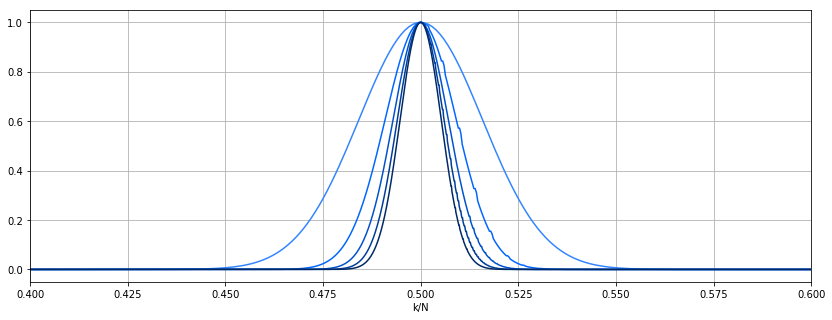

In [15]:
p = 0.5
N_list = [1000, 3010, 5000, 7000, 9000]
color_list = ['#3385ff','#0066ff','#0052cc','#003d99','#002966']

plt.figure(figsize=(14, 5))
for index, N in enumerate(N_list):
    grid = [float(k)/N for k in range(N + 1)]
    p_grid = [P_kcp(int(k*N), N, p) for k in grid]
    plt.plot(grid, p_grid/max(p_grid), color = color_list[index])

plt.xlim([0.4, 0.6])
plt.xlabel('k/N')
plt.grid()
plt.show()

### $P_N(k)$ : Distribuição de probabilidade do resultado da pesquisa supondo desconhecimento completo da situação eleitoral
Essa função será utilizada como constante de normalização no teorema de Bayes a seguir. Pelo teorema da probabilidade total:
$$ P_N(k) = \int_0^1 P_N(k \ | \ p) \ f(p) \ dp  \ \ \ \ \ \ \ \ (2) $$

In [25]:
def P_k(k, N):
    ''' P(k)
    k: numero de "acertos".
    N: numero de tentativas.
    '''

    f_p1 = f_p()
    return integ.quad(lambda x: f_p1.subs('v0', x)*P_kcp(k, N, x), 0.0, 1.0)[0]

### $f( p \ | \ k, \ N)$ : Distribuição de probabilidade da fração de voto data pesquisa eleitoral (k, N)
Pelo teorema de Bayes da probabilidade condicional:
$$ f(p \ | \ k, \ N) = \frac{P_N(k \ | \ p) \ f(p)}{P_N(k)}  \ \ \ \ \ \ \ \ (3) $$

In [26]:
def f_pck(k, N, p, pk = False):
    ''' f(p|k)	
    k: numero de "acertos".
    N: numero de tentativas.
    k/N eh o estimador de p
    p eh a variavel da funcao
    '''
    if pk:
        return P_kcp(k,N,p)*f_p().subs('v0',p)/pk
    else:
        return P_kcp(k,N,p)*f_p().subs('v0',p)/P_k(k, N)

### Cálculo de Entropia e Informação Mútua
Para Xd v.a. discreta: 
$$ H(Xd) = -\sum_{x \ \in \ A_x}p(x)\log{p(x)} \ \ \ \ \ \ \ \ (4) $$

Para Xc v.a. contínua: 
$$ h(Xc) = -\int p(x)\log{p(x)} \ \ \ \ \ \ \ \ (5) $$

Essas expressões serão utilizadas para calcular a Informação mútua entre duas variáveis aleatórias X e Y:

$$ I(X, Y) = H(X) - H(X \ | \ Y) \ ou \ = h(X) - h(X \ | \ Y) \ \ \ \ \ \ \ \ (6)$$

É importante destacar que a informação mútua é calculada como uma média em diferentes realizações da variável aleatória Y. Na análise a seguir será calculada a diminuição de entropia para cada pesquisa eleitoral (realizações únicas de Y), o que, por abuso de linguagem, será chamado de Informação.

In [27]:
def entropia(P):
    '''
    Retorna a entropia em bits da distribuicao de probabilidade P de zero a N
    '''
    N = len(P) - 1
    return sum([-P[k]*np.log2(P[k]+1E-7) for k in range(N+1)])

def entropia_diff(f):
    '''
    Retorna entropia diferencial em nits da funcao f
    '''
    #print(type(f(0.1)))
    #print(f(0.1)*np.log(f(0.1)))
    return integ.quad(lambda x: -float(f(x))*np.log(float(f(x)) + 1E-6), 0.000001, 0.999999)[0]


## Evolução da entropia de $P_N(k \ | \ p)$ em função de número de amostras
A entropia máxima de uma variável aleatória sobre um espaço amostral de N elementos é dada por $\log{N}$. Isso provoca uma distorção entre distribuições equivalentes com Ns distintos.

Seja $X_1$ v.a. sobre $A_{X_1} = \{1,2,3,...,N\}$ com função massa de probabilidade $p_1(x)$. Podemos construir a v.a. $X_1$ sobre $A_{X_2} = \{1,...,2N\}$ com função de probabilidade tal que $p_2(x = 2n) = p_2(x = 2n - 1) = \frac{1}{2} p_1(x = n)$.

Utilizar a entropia para comparar ambas as distribuições não é útil, uma vez que

$$ H(X_2) = -\sum_{x \ \in \ A_{X_2}}p_2(x)\log{p_2(x)} = -\sum_{x_a \ \in \ A_{X_1}}\frac{1}{2}p_1(x_a)\log{\frac{1}{2}p_1(x_a)}-\sum_{x_b \ \in \ A_{X_1}}\frac{1}{2}p_1(x_b)\log{\frac{1}{2}p_1(x_b)}$$

$$\rightarrow H(X_2)= H(X_1) + \log{2} \ \ \ \ \ \ \ \ (7) $$

Onde $x_a = \frac{x}{2}$, para cada x par $\in A_{X_2}$ e $x_a = \frac{x-1}{2}$ para cada x ímpar $\in A_{X_2}$.


Como $ \log{2N} = \log{N} + \log{2} $, podemos então definir a quantidade $ C = \log{N} - H_N(X) $ para anular a parcela da entropia que cresce devido ao espaço amostral e quantificar apenas a variação referente à diminuição da variância da função de probabilidade, em função de N.

Parametros do fit exponencial a*exp(-b*N) + c: 
[ 0.49932805 -1.03880824]


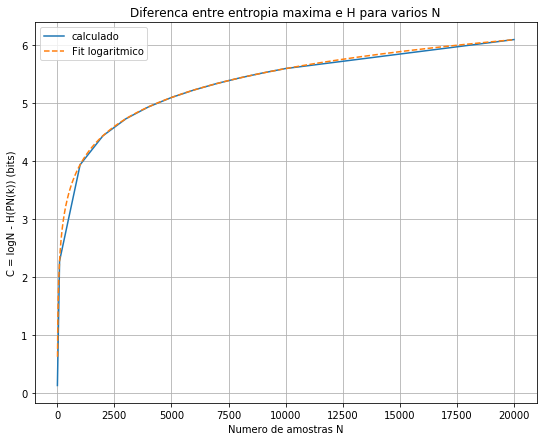

In [19]:
def exp_fit(x, a, b):
    return a * np.log2(x) + b

# Calculo da entropia das distribuicoes de probabilidade.
N_list = [5, 100, 1000, 2000, 3010, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000]
entropia_list = [0.12373654946068902, 2.2748523954998507 ,3.9358202161891516, 4.4358294685903212, 
                 4.7307183438823097, 4.9358424583848164, 5.0968116962703389, 5.2283335721647219, 
                 5.3395340643474345, 5.4358605756923914, 5.520826796531539, 5.5968318526127492, 6.0968599181659933]

#entropia_list = []
#for N in N_list:
#    P = [P_kcp(k, N, 0.5) for k in range(N + 1)]
#    dH = np.log2(N) - entropia(P)
#    entropia_list.append(dH)
#print entropia_list

#Fit exponencial à curva.
p = curve_fit(exp_fit, N_list, entropia_list, bounds = ([-7, -10], [20, 10]))[0]

grid = [float(z)/10.0 for z in range(100, 200000+1)]
exp_fit_list = [exp_fit(z, p[0], p[1]) for z in grid]
print 'Parametros do fit exponencial a*exp(-b*N) + c: '
print p

plt.figure(figsize=(9, 7))
plt.ylabel('C = logN - H(PN(k)) (bits)')
plt.xlabel('Numero de amostras N')
plt.title('Diferenca entre entropia maxima e H para varios N')

plt.plot(N_list, entropia_list, label = 'calculado')
plt.plot(grid, exp_fit_list, label = 'Fit logaritmico', linestyle = '--')

plt.legend()
plt.grid()
plt.show()


O fit resulta em: $$ H(P_N) = \log{N} - 0.49932\log{N} + 1.0388 = \log{(2.0545*N^{0.50068})}$$

É notável que o valor de C da função de probabilidade $P_N(k | p)$ é indefinidamente grande por possuir um crescimento logarítmico. Dessa forma, essa função não é útil para estipular um "valor eficiente" para N, mas por outro lado indica que um aumento fixo no volume de amostras N diminui de eficiência para valores maiores de N.

## Evolução da previsão do voto das pesquisas eleitorais de 2018

Em posse do resultado das eleições e da metodologia utilizada para cada pesquisa eleitoral, é possível realizar um teste de hipótese simples com base nas ferramentas desenvolvidas:
* H0: A distribuição de intenção de voto da população no dia da pesquisa é igual ao resultado das eleições
* H1: A distribuição de intenção de voto é diferente do resultado das eleições

Os resultados serão interpretados com nível de confiança de 95%.

In [29]:
# real:  B: 0.4985, H: 0.4058, N:0.0957
# IBOPE
# 28/10: N = 30000, B: 51.5%, H:40.5%, N: 8%
# 27/10: N = 3010,  B: 47%,   H:41%,   N:10%, I:2%
# 23/10: N = 3010,  B: 50%,   H:37%,   N:10%, I:3%
# 15/10: N = 2506,  B: 52%,   H: 37%,  N+I: 11%

pb_r = 0.4985
ph_r = 0.4058
pn_r = 0.0957
N = [30000, 3010, 3010, 2506,     18371, 9137, 3235 ]
pb = [0.515, 0.47, 0.50, 0.52,     0.47, 0.50, 0.49 ]
ph = [0.405, 0.41, 0.37, 0.37,     0.39, 0.35, 0.36 ]
pn = [0.08, 0.10, 0.10, 0.10,      0.08, 0.10, 0.08 ]
pi = [0.00, 0.02, 0.03, 0.01,      0.05, 0.05, 0.06 ]


In [347]:
# Realiza o teste de hipótese
p_valor_b = []
p_valor_h = []
for i in range(7):
    
    if pb[i] >= pb_r:
        p_valor_b.append( sum([P_kcp(k, N[i], pb_r) for k in range( int(N[i] * pb[i]), N[i] + 1)]) + \
                          sum([P_kcp(k, N[i], pb_r) for k in range(2*int(N[i] * pb_r) - int(N[i] * pb[i]))]))
    else:
        p_valor_b.append( sum([P_kcp(k, N[i], pb_r) for k in range(int(N[i] * pb[i]))]) + \
                    sum([P_kcp(k, N[i], pb_r) for k in range(2*int(N[i] * pb_r) - int(N[i] * pb[i]), N[i] + 1)]))
            
    if ph[i] >= ph_r:
        p_valor_h.append( sum([P_kcp(k, N[i], ph_r) for k in range(int(N[i] * ph[i]), N[i] + 1)]) + \
                    sum([P_kcp(k, N[i], ph_r) for k in range(2*int(N[i] * ph_r) - int(N[i] * ph[i]))]))
    else:
        p_valor_h.append( sum([P_kcp(k, N[i], ph_r) for k in range(int(N[i] * ph[i]))]) + \
                    sum([P_kcp(k, N[i], ph_r) for k in range(2*int(N[i] * ph_r) - int(N[i] * ph[i]), N[i] + 1)]))
# Print results 
print("\n        Pesquisa | Bolsonaro | Haddad | Nulo/Branco | Indeciso | p-valor (b) | p-valor (h) | Amostras")
print("     Resultado   |   %.3f   |  %.3f |    %.3f    |     -    |              |          |" % (pb_r, ph_r, pn_r))
print(" IBOPE |  28/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[0], ph[0], pn[0], pi[0], p_valor_b[0], p_valor_h[0], N[0]))
print(" IBOPE |  27/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[1], ph[1], pn[1], pi[1], p_valor_b[1], p_valor_h[1], N[1]))
print(" IBOPE |  23/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[2], ph[2], pn[2], pi[2], p_valor_b[2], p_valor_h[2], N[2]))
print(" IBOPE |  15/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[3], ph[3], pn[3], pi[3], p_valor_b[3], p_valor_h[3], N[3]))

print("DFOLHA |  26/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[4], ph[4], pn[4], pi[4], p_valor_b[4], p_valor_h[4], N[4]))
print("DFOLHA |  18/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[5], ph[5], pn[5], pi[5], p_valor_b[5], p_valor_h[5], N[5]))
print("DFOLHA |  10/10  |   %.3f   |  %.3f |    %.3f    |   %.3f  |     %.3f    |   %.3f  |  %d" % (pb[6], ph[6], pn[6], pi[6], p_valor_b[6], p_valor_h[6], N[6]))
        


        Pesquisa | Bolsonaro | Haddad | Nulo/Branco | Indeciso | p-valor (b) | p-valor (h) | Amostras
     Resultado   |   0.498   |  0.406 |    0.096    |     -    |              |          |
 IBOPE |  28/10  |   0.515   |  0.405 |    0.080    |   0.000  |     0.000    |   0.778  |  30000
 IBOPE |  27/10  |   0.470   |  0.410 |    0.100    |   0.020  |     0.002    |   0.630  |  3010
 IBOPE |  23/10  |   0.500   |  0.370 |    0.100    |   0.030  |     0.855    |   0.000  |  3010
 IBOPE |  15/10  |   0.520   |  0.370 |    0.100    |   0.010  |     0.031    |   0.000  |  2506
DFOLHA |  26/10  |   0.470   |  0.390 |    0.080    |   0.050  |     0.000    |   0.000  |  18371
DFOLHA |  18/10  |   0.500   |  0.350 |    0.100    |   0.050  |     0.770    |   0.000  |  9137
DFOLHA |  10/10  |   0.490   |  0.360 |    0.080    |   0.060  |     0.343    |   0.000  |  3235


Ou seja, para todas as pesquisas (inclusive a pesquisa de boca de urna), podemos rejeitar a hipótese nula para ao menos um candidato.

## Análise do resultado das pesquisas: a função $f(p \ | \ k)$

#### Cálculo de margem de confiança

In [30]:
def margem_de_confianca(x_list, f_list, p):
    soma = [sum([f_list[j] 
                  for j in range(1, len(x_list)) 
                  if np.abs(p - x_list[j]) > x_list[k]])
             for k in range(1, int(len(x_list)*min([p, 1 - p])))]
    dist = [abs(y/len(x_list) - 0.05) for y in soma]
    conf = x_list[dist.index(min(dist))]
    return conf

### IBOPE - Pesquisa de boca de urna (28/10)


In [33]:
i = 0
x_list0 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b0 = P_k(int(N[i]*pb[i]), N[i])
pk_h0 = P_k(int(N[i]*ph[i]), N[i])

f_b_list0 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b0) for x in x_list0]
f_h_list0 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h0)/61737.33928859094 for x in x_list0] #correção calculada abaixo

#### Cálculo de intervalo de confiança

In [337]:
conf_b0 = margem_de_confianca(x_list0, f_b_list0, pb[0])
conf_h0 = margem_de_confianca(x_list0, f_h_list0, ph[0])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[i], conf_b0))
print('Haddad:    %.3f +- %.3f' % (ph[i], conf_h0))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.515 +- 0.005
Haddad:    0.405 +- 0.005


In [338]:
# correção
fh0 = lambda x: f_pck(int(N[0]*ph[0]), N[0], x, pk = pk_h)
integ.quad(fh0, 0.000001, 0.999999)[0]

61737.33928859094

#### Cálculo de informação mútua

In [186]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb0 = lambda x: f_pck(int(N[0]*pb[0]), N[0], x, pk = pk_b0)
fh0 = lambda x: f_pck(int(N[0]*ph[0]), N[0], x, pk = pk_h0)/61737.33928859094
h_b0 = entropia_diff(fb0)
h_h0 = entropia_diff(fh0)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b0)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h0)

Informação mútua adquirida na f.d.p de Bolsonaro (nits):  4.23605419461
Informação mútua adquirida na f.d.p de Haddad (nits):  4.253993234


#### Demonstração da função $f(p | k, N)$

O gráfico abaixo ilustra o resultado final da pesquisa eleitoral de 28/10 sobre a distribuição de probabilidade da intenção de voto. Os gráficos serão omitidos para os cálculos seguintes, mas podem ser obtidos de forma análoga.

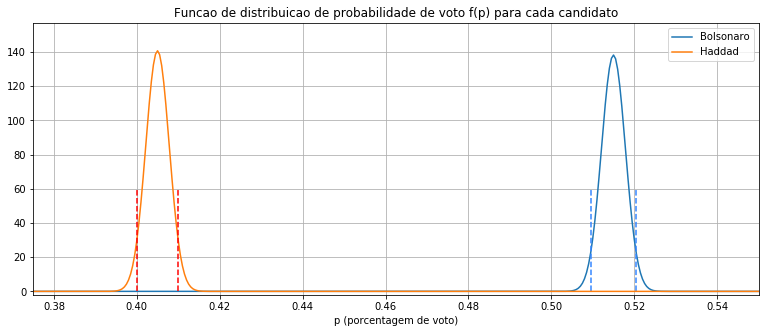

In [340]:
plt.figure(figsize=(13, 5))

plt.plot(x_list0, f_b_list0, label = 'Bolsonaro')
plt.plot([pb[0] - conf_b0, pb[0] - conf_b0],[0, 60], linestyle = '--', color = '#3385ff')
plt.plot([pb[0] + conf_b0, pb[0] + conf_b0],[0, 60], linestyle = '--', color = '#3385ff')

plt.plot(x_list0, [x for x in f_h_list0], label = 'Haddad')
plt.plot([ph[0] - conf_h0, ph[0] - conf_h0],[0, 60], linestyle = '--', color = 'r')
plt.plot([ph[0] + conf_h0, ph[0] + conf_h0],[0, 60], linestyle = '--', color = 'r')

plt.xlim([0.375,0.55])
plt.ylim([-2,157])

plt.title('Funcao de distribuicao de probabilidade de voto f(p | k,N) para cada candidato')
plt.xlabel('p (porcentagem de voto)')

plt.grid()
plt.legend()
plt.show()

### IBOPE - Pesquisa do dia 27/10

In [209]:
i = 1
x_list1 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b1 = P_k(int(N[i]*pb[i]), N[i])
pk_h1 = P_k(int(N[i]*ph[i]), N[i])

f_b_list1 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b1) for x in x_list1]
f_h_list1 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h1) for x in x_list1]

#### Cálculo de intervalo de confiança

In [210]:
conf_b1 = margem_de_confianca(x_list1, f_b_list1, pb[1])
conf_h1 = margem_de_confianca(x_list1, f_h_list1, ph[1])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[1], conf_b1))
print('Haddad:    %.3f +- %.3f' % (ph[1], conf_h1))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.470 +- 0.018
Haddad:    0.410 +- 0.017


#### Cálculo de informação mútua

In [212]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb1 = lambda x: f_pck(int(N[1]*pb[1]), N[1], x, pk = pk_b1)
h_b1 = entropia_diff(fb1)
fh1 = lambda x: f_pck(int(N[1]*ph[1]), N[1], x, pk = pk_h1)
h_h1 = entropia_diff(fh1)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b1)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h1)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 3.088423
Informação mútua adquirida na f.d.p de Haddad (nits): 3.103098


### IBOPE - Pesquisa do dia 23/10

In [201]:
i = 2
x_list2 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b2 = P_k(int(N[i]*pb[i]), N[i])
pk_h2 = P_k(int(N[i]*ph[i]), N[i])

f_b_list2 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b2) for x in x_list2]
f_h_list2 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h2) for x in x_list2]

#### Cálculo de intervalo de confiança

In [202]:
conf_b2 = margem_de_confianca(x_list2, f_b_list2, pb[2])
conf_h2 = margem_de_confianca(x_list2, f_h_list2, ph[2])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[2], conf_b2))
print('Haddad:    %.3f +- %.3f' % (ph[2], conf_h2))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.500 +- 0.018
Haddad:    0.370 +- 0.017


#### Cálculo de informação mútua

In [204]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb2 = lambda x: f_pck(int(N[2]*pb[2]), N[2], x, pk = pk_b2)
fh2 = lambda x: f_pck(int(N[2]*ph[2]), N[2], x, pk = pk_h2)
h_b2 = entropia_diff(fb2)
h_h2 = entropia_diff(fh2)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b2)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h2)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 3.086574
Informação mútua adquirida na f.d.p de Haddad (nits): 3.121753


### IBOPE - Pesquisa do dia 15/10

In [205]:
i = 3
x_list3 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b3 = P_k(int(N[i]*pb[i]), N[i])
pk_h3 = P_k(int(N[i]*ph[i]), N[i])

f_b_list3 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b3) for x in x_list3]
f_h_list3 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h3) for x in x_list3]

#### Cálculo de intervalo de confiança

In [206]:
conf_b3 = margem_de_confianca(x_list3, f_b_list3, pb[3])
conf_h3 = margem_de_confianca(x_list3, f_h_list3, ph[3])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[3], conf_b3))
print('Haddad:    %.3f +- %.3f' % (ph[3], conf_h3))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.520 +- 0.019
Haddad:    0.370 +- 0.018


#### Cálculo de informação mútua

In [208]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb3 = lambda x: f_pck(int(N[3]*pb[3]), N[3], x, pk = pk_b3)
fh3 = lambda x: f_pck(int(N[3]*ph[3]), N[3], x, pk = pk_h3)
h_b3 = entropia_diff(fb3)
h_h3 = entropia_diff(fh3)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b3)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h3)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 2.995861
Informação mútua adquirida na f.d.p de Haddad (nits): 3.030190


### DataFolha - Pesquisa do dia 26/10

In [214]:
i = 4
x_list4 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b4 = P_k(int(N[i]*pb[i]), N[i])
pk_h4 = P_k(int(N[i]*ph[i]), N[i])

f_b_list4 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b4) for x in x_list4]
f_h_list4 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h4) for x in x_list4]

#### Cálculo de intervalo de confiança

In [215]:
conf_b4 = margem_de_confianca(x_list4, f_b_list4, pb[4])
conf_h4 = margem_de_confianca(x_list4, f_h_list4, ph[4])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[4], conf_b4))
print('Haddad:    %.3f +- %.3f' % (ph[4], conf_h4))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.470 +- 0.006
Haddad:    0.390 +- 0.007


#### Cálculo de informação mútua

In [221]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb4 = lambda x: f_pck(int(N[4]*pb[4]), N[4], x, pk = pk_b4)
fh4 = lambda x: f_pck(int(N[4]*ph[4]), N[4], x, pk = pk_h4)
h_b4 = entropia_diff(fb4)
h_h4 = entropia_diff(fh4)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b4)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h4)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 3.992244
Informação mútua adquirida na f.d.p de Haddad (nits): 4.015266


### DataFolha - Pesquisa do dia 18/10

In [222]:
i = 5
x_list5 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b5 = P_k(int(N[i]*pb[i]), N[i])
pk_h5 = P_k(int(N[i]*ph[i]), N[i])

f_b_list5 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b5) for x in x_list5]
f_h_list5 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h5) for x in x_list5]

#### Cálculo de intervalo de confiança

In [223]:
conf_b5 = margem_de_confianca(x_list5, f_b_list5, pb[5])
conf_h5 = margem_de_confianca(x_list5, f_h_list5, ph[5])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[5], conf_b5))
print('Haddad:    %.3f +- %.3f' % (ph[5], conf_h5))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.500 +- 0.010
Haddad:    0.350 +- 0.009


#### Cálculo de informação mútua

In [227]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb5 = lambda x: f_pck(int(N[5]*pb[5]), N[5], x, pk = pk_b5)
fh5 = lambda x: f_pck(int(N[5]*ph[5]), N[5], x, pk = pk_h5)
h_b5 = entropia_diff(fb5)
h_h5 = entropia_diff(fh5)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b5)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h5)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 3.641324
Informação mútua adquirida na f.d.p de Haddad (nits): 3.688566


### DataFolha - Pesquisa do dia 10/10

In [25]:
i = 6
x_list6 = [float(x)/2000 for x in range(1, 2000)]
f = f_p()

pk_b6 = P_k(int(N[i]*pb[i]), N[i])
pk_h6 = P_k(int(N[i]*ph[i]), N[i])

f_b_list6 = [f_pck(int(N[i]*pb[i]), N[i], x, pk = pk_b6) for x in x_list6]
f_h_list6 = [f_pck(int(N[i]*ph[i]), N[i], x, pk = pk_h6) for x in x_list6]

#### Cálculo de intervalo de confiança

In [26]:
conf_b6 = margem_de_confianca(x_list6, f_b_list6, pb[6])
conf_h6 = margem_de_confianca(x_list6, f_h_list6, ph[6])                               

print('Considerando intervalo de confiança de 95%:')
print('Bolsonaro: %.3f +- %.3f' % (pb[6], conf_b6))
print('Haddad:    %.3f +- %.3f' % (ph[6], conf_h6))

Considerando intervalo de confiança de 95%:
Bolsonaro: 0.490 +- 0.017
Haddad:    0.360 +- 0.016


#### Cálculo de informação mútua

In [242]:
f_p1 = f_p()
f0 = lambda x: f_p1.subs('v0', x)
h_f0 = entropia_diff(f0)

fb6 = lambda x: f_pck(int(N[6]*pb[6]), N[6], x, pk = pk_b6)
fh6 = lambda x: f_pck(int(N[6]*ph[6]), N[6], x, pk = pk_h6)
h_b6 = entropia_diff(fb6)
h_h6 = entropia_diff(fh6)

print 'Informação mútua adquirida na f.d.p de Bolsonaro (nits): %f' % (h_f0 - h_b6)
print 'Informação mútua adquirida na f.d.p de Haddad (nits): %f' % (h_f0 - h_h6)


Informação mútua adquirida na f.d.p de Bolsonaro (nits): 3.122780
Informação mútua adquirida na f.d.p de Haddad (nits): 3.163557


## Evolução das pesquisas 

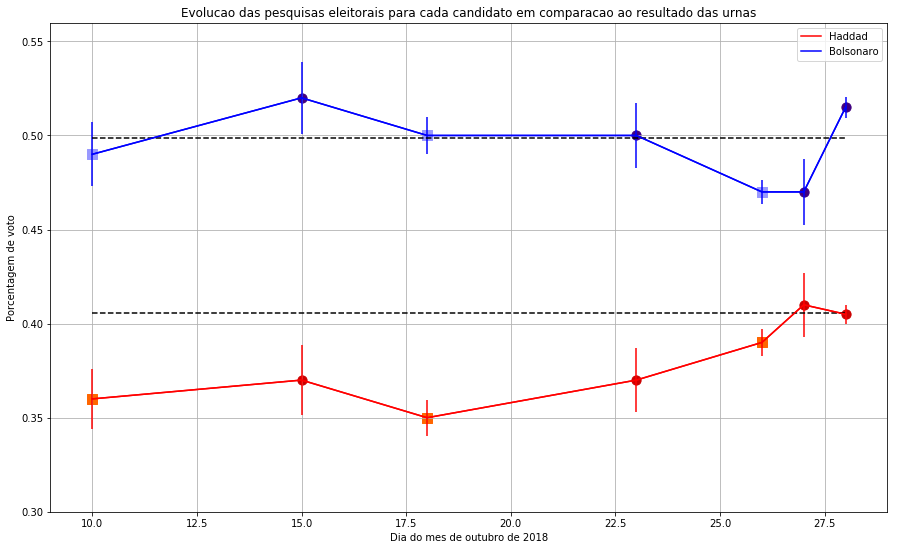

In [327]:
plt.figure(figsize=(15, 9))
ph_ev = [ph[6], ph[3], ph[5], ph[2], ph[4], ph[1], ph[0]]
pb_ev = [pb[6], pb[3], pb[5], pb[2], pb[4], pb[1], pb[0]]
dias = [10, 15, 18, 23, 26, 27, 28]

plt.plot(dias, ph_ev, color = 'r', label = 'Haddad')
plt.scatter([dias[0], dias[2], dias[4]], [ph_ev[0], ph_ev[2], ph_ev[4]], 
            color = '#ff6600', marker = 's', s = 85)
plt.scatter([dias[1], dias[3], dias[5], dias[6]], [ph_ev[1], ph_ev[3], ph_ev[5], ph_ev[6]], color = '#cc0000', marker = 'o', s = 85)
plt.errorbar(dias, ph_ev, yerr = [conf_h6, conf_h3, conf_h5, conf_h2, conf_h4, conf_h1, conf_h0], color = 'r')
plt.plot([10, 28], [ph_r, ph_r], linestyle = '--', color = 'k')

plt.plot(dias, pb_ev, color = 'b', label = 'Bolsonaro')
plt.scatter([dias[0], dias[2], dias[4]], [pb_ev[0], pb_ev[2], pb_ev[4]], 
             color = '#9999ff', marker = 's', s = 85 )
plt.scatter([dias[1], dias[3], dias[5], dias[6]], [pb_ev[1], pb_ev[3], pb_ev[5], pb_ev[6]], 
             color = '#400080', marker = 'o', s = 85)
plt.errorbar(dias, pb_ev, yerr = [conf_b6, conf_b3, conf_b5, conf_b2, conf_b4, conf_b1, conf_b0], color = 'b')
plt.plot([10, 28], [pb_r, pb_r], linestyle = '--', color = 'k')

plt.xlim([9, 29])
plt.ylim([0.3, 0.56])

plt.title('Evolucao das pesquisas eleitorais para cada candidato em comparacao ao resultado das urnas')
plt.ylabel('Porcentagem de voto')
plt.xlabel('Dia do mes de outubro de 2018')
plt.legend()
plt.grid()

No gráfico acima, pesquisas Datafolha estão representadas por quadrados, e IBOPE, por círculos

## Relação entre Informação Mútua e grau de confiança

Parametros do fit exponencial a*exp(-b*N) + c: 
[ 0.33436087  0.93836358 -0.00100621]


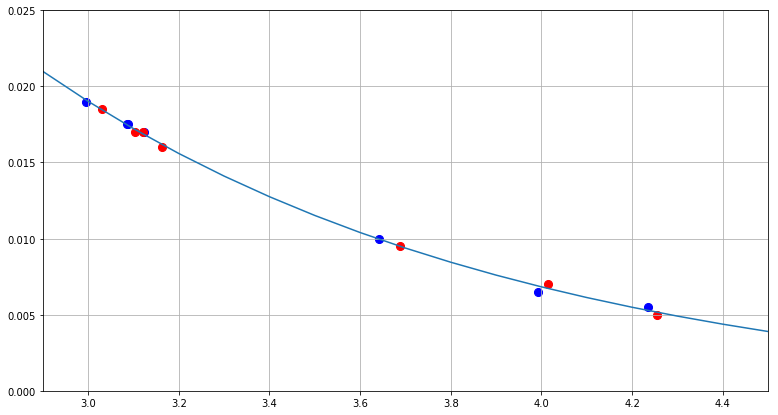

In [335]:
def exp_fit(x, a, b, c):
    return a * np.exp(-b*x) + c

plt.figure(figsize=(13, 7))

inform_h = [h_f0 - h_h0, h_f0 - h_h1, h_f0 - h_h2, h_f0 - h_h3, h_f0 - h_h4, h_f0 - h_h5, h_f0 - h_h6]
inform_b = [h_f0 - h_b0, h_f0 - h_b1, h_f0 - h_b2, h_f0 - h_b3, h_f0 - h_b4, h_f0 - h_b5, h_f0 - h_b6]
confiabilidade_b = [conf_b0, conf_b1, conf_b2, conf_b3, conf_b4, conf_b5, conf_b6]
confiabilidade_h = [conf_h0, conf_h1, conf_h2, conf_h3, conf_h4, conf_h5, conf_h6]

plt.xlim([2.9, 4.5])
plt.ylim([0.0, 0.025])
plt.scatter(inform_b, confiabilidade_b, color = 'b', s = 65)
plt.scatter(inform_h, confiabilidade_h, color = 'r', s = 65)
plt.grid()

p = curve_fit(exp_fit, inform_b + inform_h, confiabilidade_b + confiabilidade_h, bounds = ([-1,-1,-1],[2,2,1]) )[0]
grid = [float(z)/10.0 for z in range(25, 50)]
exp_fit_list = [exp_fit(z, p[0], p[1], p[2]) for z in grid]
plt.plot(grid, exp_fit_list)
print 'Parametros do fit exponencial a*exp(-b*N) + c: '
print p

Vemos pelo gráfico uma correlação interessante entre a informação mútua obtida por uma pesquisa eleitoral e sua margem de erro. Assumindo que à Informação mútua nula a margem de erro é maior que 0.5 e que o decaimento exponencial converge a zero, temos a seguinte curva:

Parametros do fit exponencial a*exp(-b*N) + c: 
[ 0.5000129   1.08488574  0.        ]


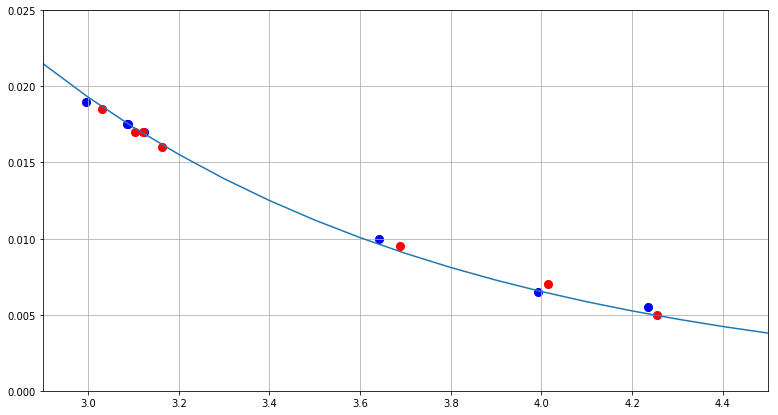

In [336]:
def exp_fit(x, a, b, c):
    return a * np.exp(-b*x)

plt.figure(figsize=(13, 7))

inform_h = [h_f0 - h_h0, h_f0 - h_h1, h_f0 - h_h2, h_f0 - h_h3, h_f0 - h_h4, h_f0 - h_h5, h_f0 - h_h6]
inform_b = [h_f0 - h_b0, h_f0 - h_b1, h_f0 - h_b2, h_f0 - h_b3, h_f0 - h_b4, h_f0 - h_b5, h_f0 - h_b6]
confiabilidade_b = [conf_b0, conf_b1, conf_b2, conf_b3, conf_b4, conf_b5, conf_b6]
confiabilidade_h = [conf_h0, conf_h1, conf_h2, conf_h3, conf_h4, conf_h5, conf_h6]

plt.xlim([2.9, 4.5])
plt.ylim([0.0, 0.025])
plt.scatter(inform_b, confiabilidade_b, color = 'b', s = 65)
plt.scatter(inform_h, confiabilidade_h, color = 'r', s = 65)
plt.grid()

p = curve_fit(exp_fit, inform_b + inform_h, confiabilidade_b + confiabilidade_h, bounds = ([0.5,-1,-1],[2,2,1]) )[0]
grid = [float(z)/10.0 for z in range(25, 50)]
exp_fit_list = [exp_fit(z, p[0], p[1], p[2]) for z in grid]
plt.plot(grid, exp_fit_list)
print 'Parametros do fit exponencial a*exp(-b*N) + c: '
print p

Sugere-se então a expressão:
$$ E = 50\exp^{-1.085 \ I} $$

Onde E é dado como o erro em pontos percentuais para mais ou para menos.

## Conclusão

A análise detalhada das funções de probabilidade de voto revelaram que cada pesquisa apresentou uma margem de erro incoerente com o resultado final das eleições para ao menos um candidato. Isso indica uma evolução das intenções da população gerada por fatores exógenos como a estratégia eleitoral, a influência de mídias diversas e a própria divulgação de pesquisas eleitorais. Trabalhos futuros poderiam incluir uma análise temporal mais aprofundada, com o objetivo de modelar tais fatores. Também foram encontradas relações interessantes entre os resultados das pesquisas e a Informação obtida, que validam sua interpretação qualtitativa.